# Ground-truth
The response codes:
- PD = progressive diseases, cancer has grown since before; 
- SD = stable disease, cancer stayed roughly the same; 
- PR = partial response, cancer reduced somewhat; 
- CR = complete response, cancer seems mostly eliminated at the moment.

But could be grouped by:
- PR/CR = response to treatment
- SD/PD = no response to treatment


In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import os 

In [2]:
# Load the Excel file
df = pd.read_excel("Clinical info_v2.2.xlsx",sheet_name=1)

# Sort by Patient_id and Days to ensure the latest entry per patient is last
df_sorted = df.sort_values(['Patient_id', 'Days'])
print(df_sorted)

    Patient_id  Days Blood sample Clinical response Systemic treatment  \
0      SARK011     0          Yes                PD        Neoadjuvant   
1      SARK011    20          Yes                PD        Neoadjuvant   
2      SARK011    95          Yes                SD        Neoadjuvant   
3      SARK011    97          Yes                CR      Off-treatment   
4      SARK011   178          Yes                CR           Adjuvant   
..         ...   ...          ...               ...                ...   
140    SARK059    98          Yes                CR           Adjuvant   
141    SARK059   126          Yes                CR           Adjuvant   
142    SARK059   147          Yes                CR           Adjuvant   
143    SARK059   168          Yes                CR           Adjuvant   
144    SARK059   317          Yes                CR      Off-treatment   

    Radiotherapy Surgery  Death  
0            NaN     NaN    NaN  
1            NaN     NaN    NaN  
2        

We plot how the disease progression evolves over time for each patient (even those excluded).

In [3]:
def save_figure(fig, file_prefix,foldername=None):
    current_path = os.getcwd()
    if foldername==None:
        save_folder = os.path.join(current_path, f'Results/GT')
    else:
        save_folder = os.path.join(current_path, f'Results/GT/{foldername}')
    os.makedirs(save_folder, exist_ok=True)
    png_path = os.path.join(save_folder, f"{file_prefix}.png")
    pdf_path = os.path.join(save_folder, f"{file_prefix}.pdf")
    fig.savefig(png_path, bbox_inches='tight')
    fig.savefig(pdf_path, bbox_inches='tight')


In [4]:
plt.rcParams.update({
    "font.size": 15,       # Default text size
    "axes.titlesize": 17,  # Title size
    "axes.labelsize": 15,  # X and Y label size
    "xtick.labelsize": 12, # X tick labels
    "ytick.labelsize": 13, # Y tick labels
    "legend.fontsize": 15,  # Legend text size
    "lines.linewidth": 3  # Increase line thickness
})

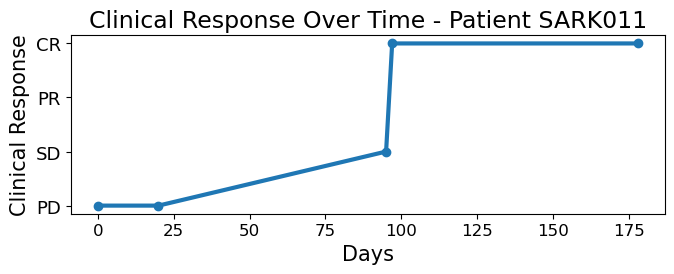

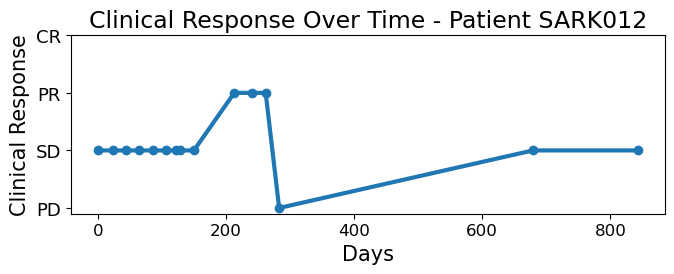

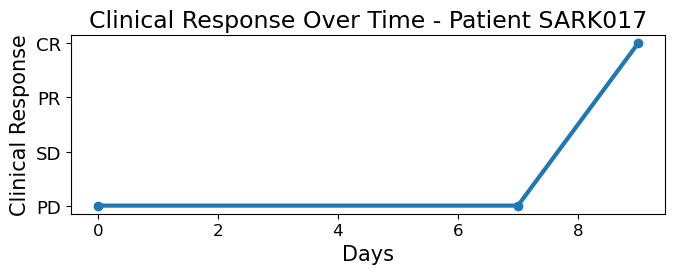

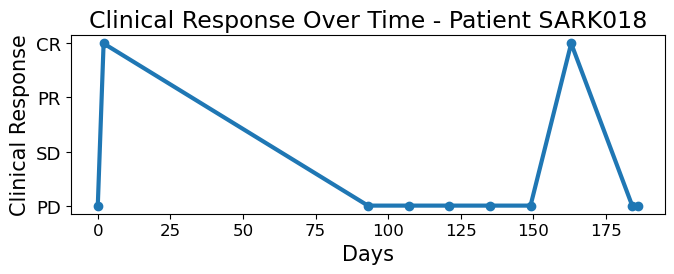

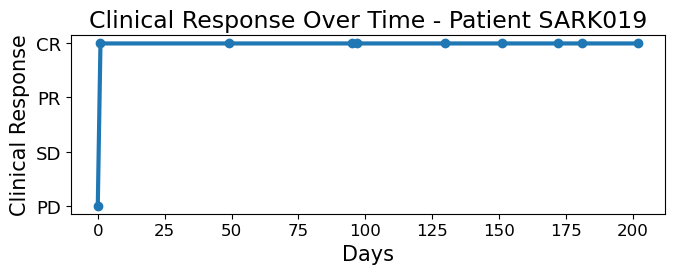

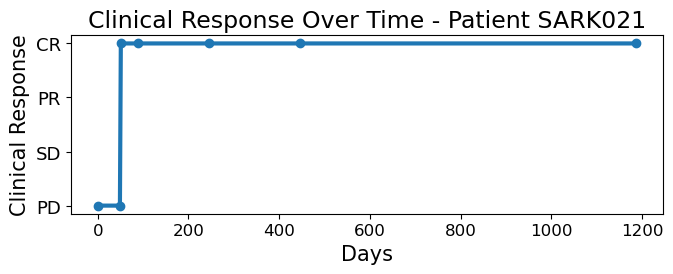

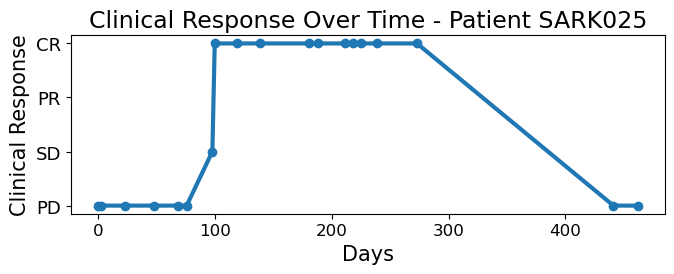

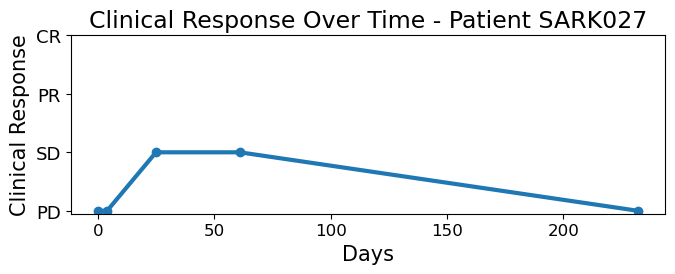

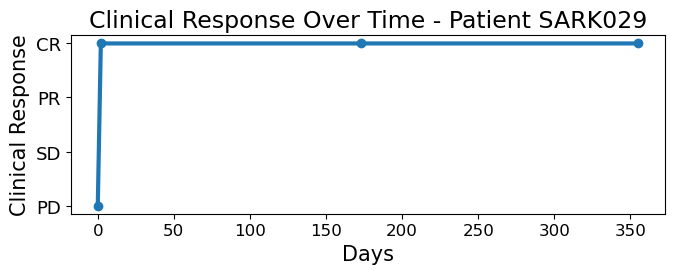

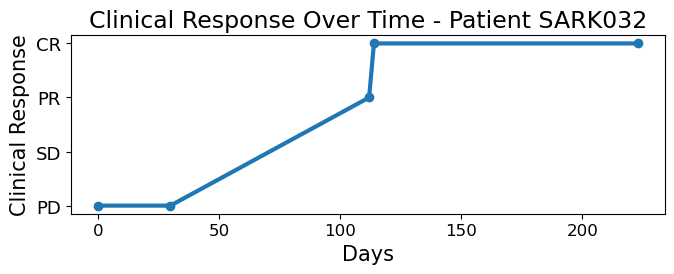

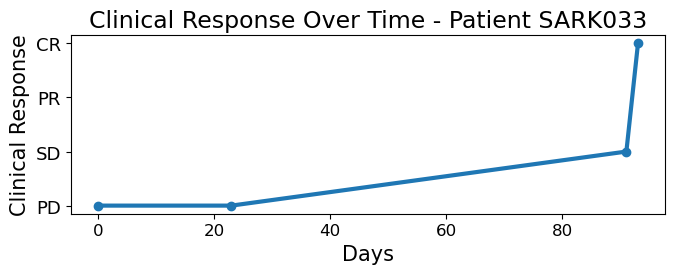

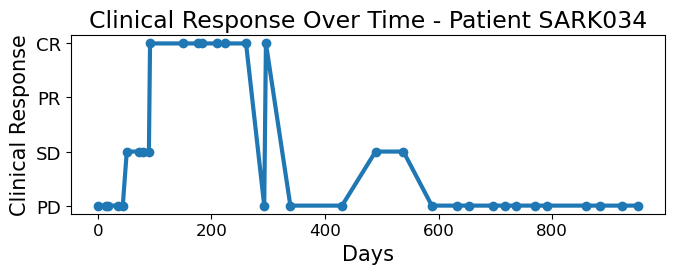

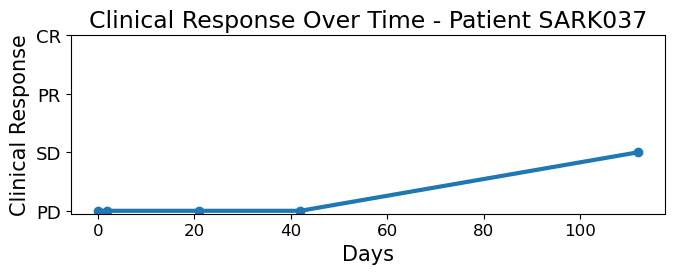

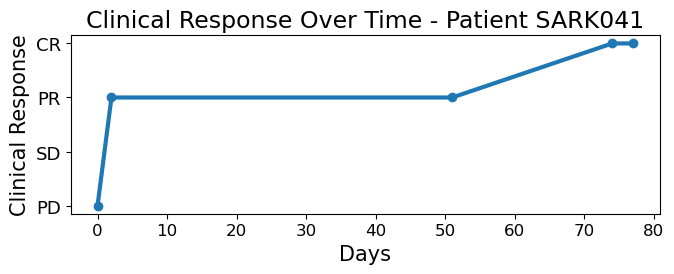

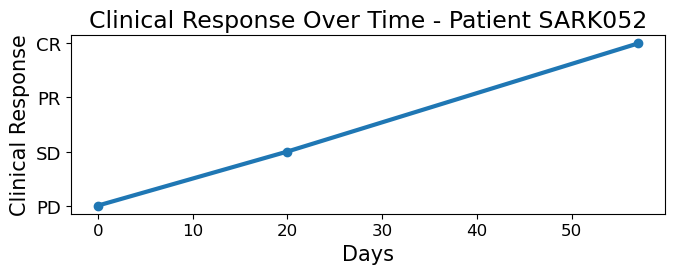

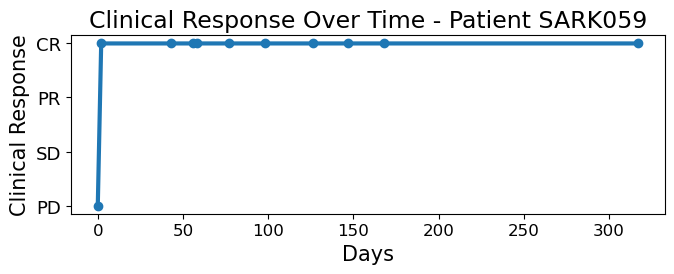

In [5]:
# Define label mapping
response_map = {'PD': 0, 'SD': 1, 'PR': 2, 'CR': 3}
inverse_map = {v: k for k, v in response_map.items()}

# Map clinical response to numeric values
df['Response_numeric'] = df['Clinical response'].map(response_map)

# Drop rows with no valid response
df_filtered = df.dropna(subset=['Response_numeric'])

# Sort data
df_filtered = df_filtered.sort_values(['Patient_id', 'Days'])

# Plot per patient
for patient_id, group in df_filtered.groupby('Patient_id'):
    fig=plt.figure(figsize=(7, 3))
    plt.plot(group['Days'], group['Response_numeric'], marker='o', linestyle='-')
    
    plt.title(f'Clinical Response Over Time - Patient {patient_id}')
    plt.xlabel('Days')
    plt.ylabel('Clinical Response')
    plt.yticks(ticks=[0,1,2,3], labels=[inverse_map[i] for i in range(4)])
    plt.tight_layout()
    
    save_figure(fig, f'response_{patient_id}',foldername=None)
    plt.show()


Since our clustering is based on the last time point only (for TCR metrics), we extract only the final outcome for each patient.

<!-- but overall all data (for Tucker decomposition), we extract both types of labels for comparing with each clustering method. -->

In [6]:
# Keep the last record per patient
latest_per_patient = df_sorted.groupby('Patient_id').tail(1)

# Display the summary
summary = latest_per_patient[['Patient_id', 'Days', 'Clinical response', 'Systemic treatment']]

print(summary)


    Patient_id  Days Clinical response       Systemic treatment
4      SARK011   178                CR                 Adjuvant
19     SARK012   843                SD      Palliative targeted
22     SARK017     9                CR            Off-treatment
32     SARK018   186                PD            Off-treatment
42     SARK019   202                CR                Adjuvant 
49     SARK021  1187                CR            Off-treatment
68     SARK025   462                PD                 Adjuvant
73     SARK027   232                PD  Palliative chemotherapy
77     SARK029   355                CR            Off-treatment
82     SARK032   223                CR            Off-treatment
86     SARK033    93                CR            Off-treatment
120    SARK034   951                PD      Palliative targeted
125    SARK037   112                SD  Palliative chemotherapy
130    SARK041    77                CR            Off-treatment
133    SARK052    57                CR  

In [7]:
# Exclude patients not used in analysis
excluded_patients = {'SARK011', 'SARK017', 'SARK052'}
summary = summary[~summary['Patient_id'].isin(excluded_patients)]

# Patient subsets from Tucker tensors
patient_lists = {
    'tensor_70': ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                  'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059'],
    'tensor_100': ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                   'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059'],
    'tensor_200': ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                   'SARK027', 'SARK029', 'SARK032', 'SARK059'],
    'tensor_300': ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
                   'SARK029', 'SARK059']
}

# Save label CSVs for each tensor and each k
for tensor_key, patient_subset in patient_lists.items():
    # Filter summary to patients in this tensor and not excluded
    filtered = summary[
        summary['Patient_id'].isin(patient_subset) & 
        ~summary['Patient_id'].isin(excluded_patients)
    ]

    # Save clinical response (outcome) as cluster label
    filtered[['Patient_id', 'Clinical response']].rename(columns={
        'Patient_id': 'patient',
        'Clinical response': 'cluster'
    }).to_csv(f'Clust_Results/labels_GT_{tensor_key}.csv', index=False)
